In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy

%matplotlib inline

## Generate Poisson data, compare two Poisson models with different priors

I will generate observed data from a Poisson distribution with a certain lambda. Then I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial with Beta prior. 

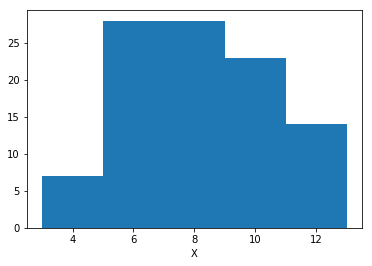

In [2]:
N = 100  # size of toy data
true_lam = 8.

# set prior parameters 
shapes = [9., 1.]
scales = [.5, 2.]


X_o = np.random.poisson(lam=true_lam, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins=5);
plt.xlabel('X');

## Define functions for generating data from the two different models

In [3]:
def generate_poisson(N, shape, scale): 
    
    # sample from prior
    theta = np.random.gamma(shape, scale)
    # generate samples
    x = np.random.poisson(lam=theta, size=N)
    
    sx = np.mean(x).astype(float)
    
    return theta, sx
    
def generate_dataset(n_samples, sample_size): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        # m_i in {0, 1} just sets the index in the array of prior hyperparams
        shape = shapes[m_i]
        scale = scales[m_i]
        theta, sx = generate_poisson(sample_size, shape, scale)
    
        X.append([sx])
        thetas.append([theta])
        m.append([int(m_i)])
    
    return m, np.array(thetas), np.array(X)

## Define separate networks for fitting the prior parameter posterior and the model posterior

In [4]:
def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.tanh = nn.Tanh()
        self.scale_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.shape_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_shape = self.scale_out(act)
        out_scale = self.shape_out(act)
        return (out_shape, out_scale)
    
    
def train(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = mdn_loss_function(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim

## Define posterior model and corresponding loss function for learning theta

In [5]:
# magical gammaln fun from pyro 
def log_gamma(xx):
    gamma_coeff = [
        76.18009172947146,
        -86.50532032941677,
        24.01409824083091,
        -1.231739572450155,
        0.1208650973866179e-2,
        -0.5395239384953e-5,
    ]
    magic1 = 1.000000000190015
    magic2 = 2.5066282746310005
    x = xx - 1.0
    t = x + 5.5
    t = t - (x + 0.5) * torch.log(t)
    ser = Variable(torch.ones(x.size()) * magic1)
    for c in gamma_coeff:
        x = x + 1.0
        ser = ser + torch.pow(x / c, -1)
    return torch.log(ser * magic2) - t


def gamma_pdf(x, shape, scale, log=False): 
    alpha = shape
    beta = 1 / scale
    
    ll_1 = -beta * x
    ll_2 = (alpha - 1.0) * torch.log(x)
    ll_3 = alpha * torch.log(beta)
    ll_4 = -log_gamma(alpha)
    result = torch.sum(ll_1 + ll_2 + ll_3 + ll_4, -1)
    if log:
        return result
    else: 
        return torch.exp(result)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_shape, out_scale, y):
    result = gamma_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [6]:
# generate data 
m, theta, X = generate_dataset(2000, 10)

In [7]:
# separate it 
mask = np.array(m).squeeze()
theta1, X1, = theta[mask==0], X[mask==0, :]
theta2, X2, = theta[mask==1], X[mask==1, :]

## Train the phi networks for estimating the theta posteriors

In [8]:
# now train the networks for the two models 
model1 = MDN_phi()
optim1 = torch.optim.Adam(model1.parameters(), lr=0.01)
model1, optim1 = train(X1, theta1, model=model1, optim=optim1)

[epoch 0050] loss: 1.1959
[epoch 0100] loss: 1.1147
[epoch 0150] loss: 0.9455
[epoch 0200] loss: 0.9241
[epoch 0250] loss: 0.9976
[epoch 0300] loss: 0.9684
[epoch 0350] loss: 0.8591
[epoch 0400] loss: 0.9662
[epoch 0450] loss: 0.9396
[epoch 0500] loss: 0.9463


In [9]:
model2 = MDN_phi()
optim2 = torch.optim.Adam(model2.parameters(), lr=0.01)
model2, optim2 = train(X2, theta2, model=model2, optim=optim2)

[epoch 0050] loss: 0.4019
[epoch 0100] loss: 0.4374
[epoch 0150] loss: 0.0627
[epoch 0200] loss: 0.3553
[epoch 0250] loss: 0.2307
[epoch 0300] loss: 0.3562
[epoch 0350] loss: 0.2463
[epoch 0400] loss: 0.3140
[epoch 0450] loss: 0.4081
[epoch 0500] loss: 0.2259


In [10]:
def get_posterior(model, X_o, thetas): 
    stats_o = np.array(np.mean(X_o).astype(float)).reshape(1, 1)

    X_var = Variable(torch.Tensor(stats_o))

    (out_shape, out_scale) = model(X_var)

    # make sure all variabel have dimensions (N, 1)
    out_shapes = Variable(torch.Tensor(out_shape.data * torch.ones(thetas.size))).view(N, 1)
    out_scales = Variable(torch.Tensor(out_scale.data * torch.ones(thetas.size))).view(N, 1)

    post = gamma_pdf(Variable(torch.Tensor(thetas.reshape(N, 1))), out_shapes, out_scales, log=False).data.numpy()
    return post

In [11]:
thetas = np.linspace(0, 10, 100)
post1 = get_posterior(model1, X_o, thetas)
post2 = get_posterior(model2, X_o, thetas)

In [12]:
prior1 = gamma.pdf(x=thetas, a=shapes[0], loc=0, scale=scales[0])
prior2 = gamma.pdf(x=thetas, a=shapes[1], loc=0, scale=scales[1])

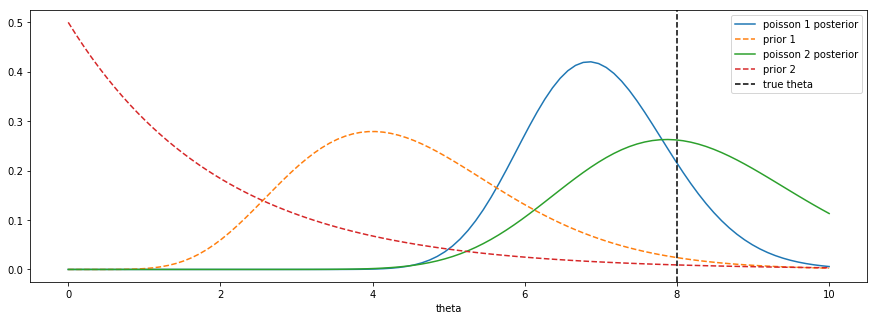

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post1.squeeze(), label='poisson 1 posterior')
plt.plot(thetas, prior1, '--', label='prior 1')

plt.plot(thetas, post2.squeeze(), label='poisson 2 posterior')
plt.plot(thetas, prior2, '--', label='prior 2')

plt.axvline(x=true_lam, label='true theta', linestyle='--', color='k')
plt.xlabel('theta')
plt.legend();

## Now train the model posterior

In [14]:
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m

lossfun = nn.CrossEntropyLoss()

def psi_loss_function(m, out): 
    M = m.size
    J = Variable(torch.Tensor([0]))

    for i in range(M):
        J += torch.log(out[i, m[i]])
        
    result = J / M
    
    return - result

def train_psi(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim

In [15]:
model = MDN_psi()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

model_psi, optim_psi = train_psi(X, m, model, optim)

[epoch 0050] loss: 0.3849
[epoch 0100] loss: 0.4861
[epoch 0150] loss: 0.3278
[epoch 0200] loss: 0.3573
[epoch 0250] loss: 0.4540
[epoch 0300] loss: 0.3516
[epoch 0350] loss: 0.4205
[epoch 0400] loss: 0.4651
[epoch 0450] loss: 0.3731
[epoch 0500] loss: 0.4308


In [16]:
stats_o = np.array(np.mean(X_o).astype(float)).reshape(1, 1)

X_var = Variable(torch.Tensor(stats_o))

(out_act) = model(X_var)

In [17]:
m = nn.Softmax()
print(m(out_act))

Variable containing:
 0.8374  0.1626
[torch.FloatTensor of size 1x2]

